<a href="https://colab.research.google.com/github/pietromarini00/30412-Classification-with-LogisticRegression/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCRIPTION
----------

This dataset is composed of 1200 samples with 35 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 5 possible values for the labels. The remaining columns are numeric
features.

Your task is the following: assuming that you want to classify this data with
Logistic Regression (implemented by sklearn.linear_model.LogisticRegression),
you should determine whether applying PCA to this dataset is useful, and if so
what number of components you would choose to use. At the end of the analysis,
you should have chosen an optimal strategy, including the optimal set of
parameters for the classifier: write this choice explicitly in the conclusions
of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

In [93]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
Data = pd.read_csv('mldata_0003094072.csv')

# Data Pre-Processing

In [3]:
labels = Data['label']
features = Data.drop(columns=['Unnamed: 0','label'])

Check that there are no missing values in each column

In [46]:
Data.isnull().any()

Unnamed: 0    False
label         False
feature_1     False
feature_2     False
feature_3     False
feature_4     False
feature_5     False
feature_6     False
feature_7     False
feature_8     False
feature_9     False
feature_10    False
feature_11    False
feature_12    False
feature_13    False
feature_14    False
feature_15    False
feature_16    False
feature_17    False
feature_18    False
feature_19    False
feature_20    False
feature_21    False
feature_22    False
feature_23    False
feature_24    False
feature_25    False
feature_26    False
feature_27    False
feature_28    False
feature_29    False
feature_30    False
feature_31    False
feature_32    False
feature_33    False
feature_34    False
feature_35    False
dtype: bool

Distributions of each feature, they already look Normally distributed

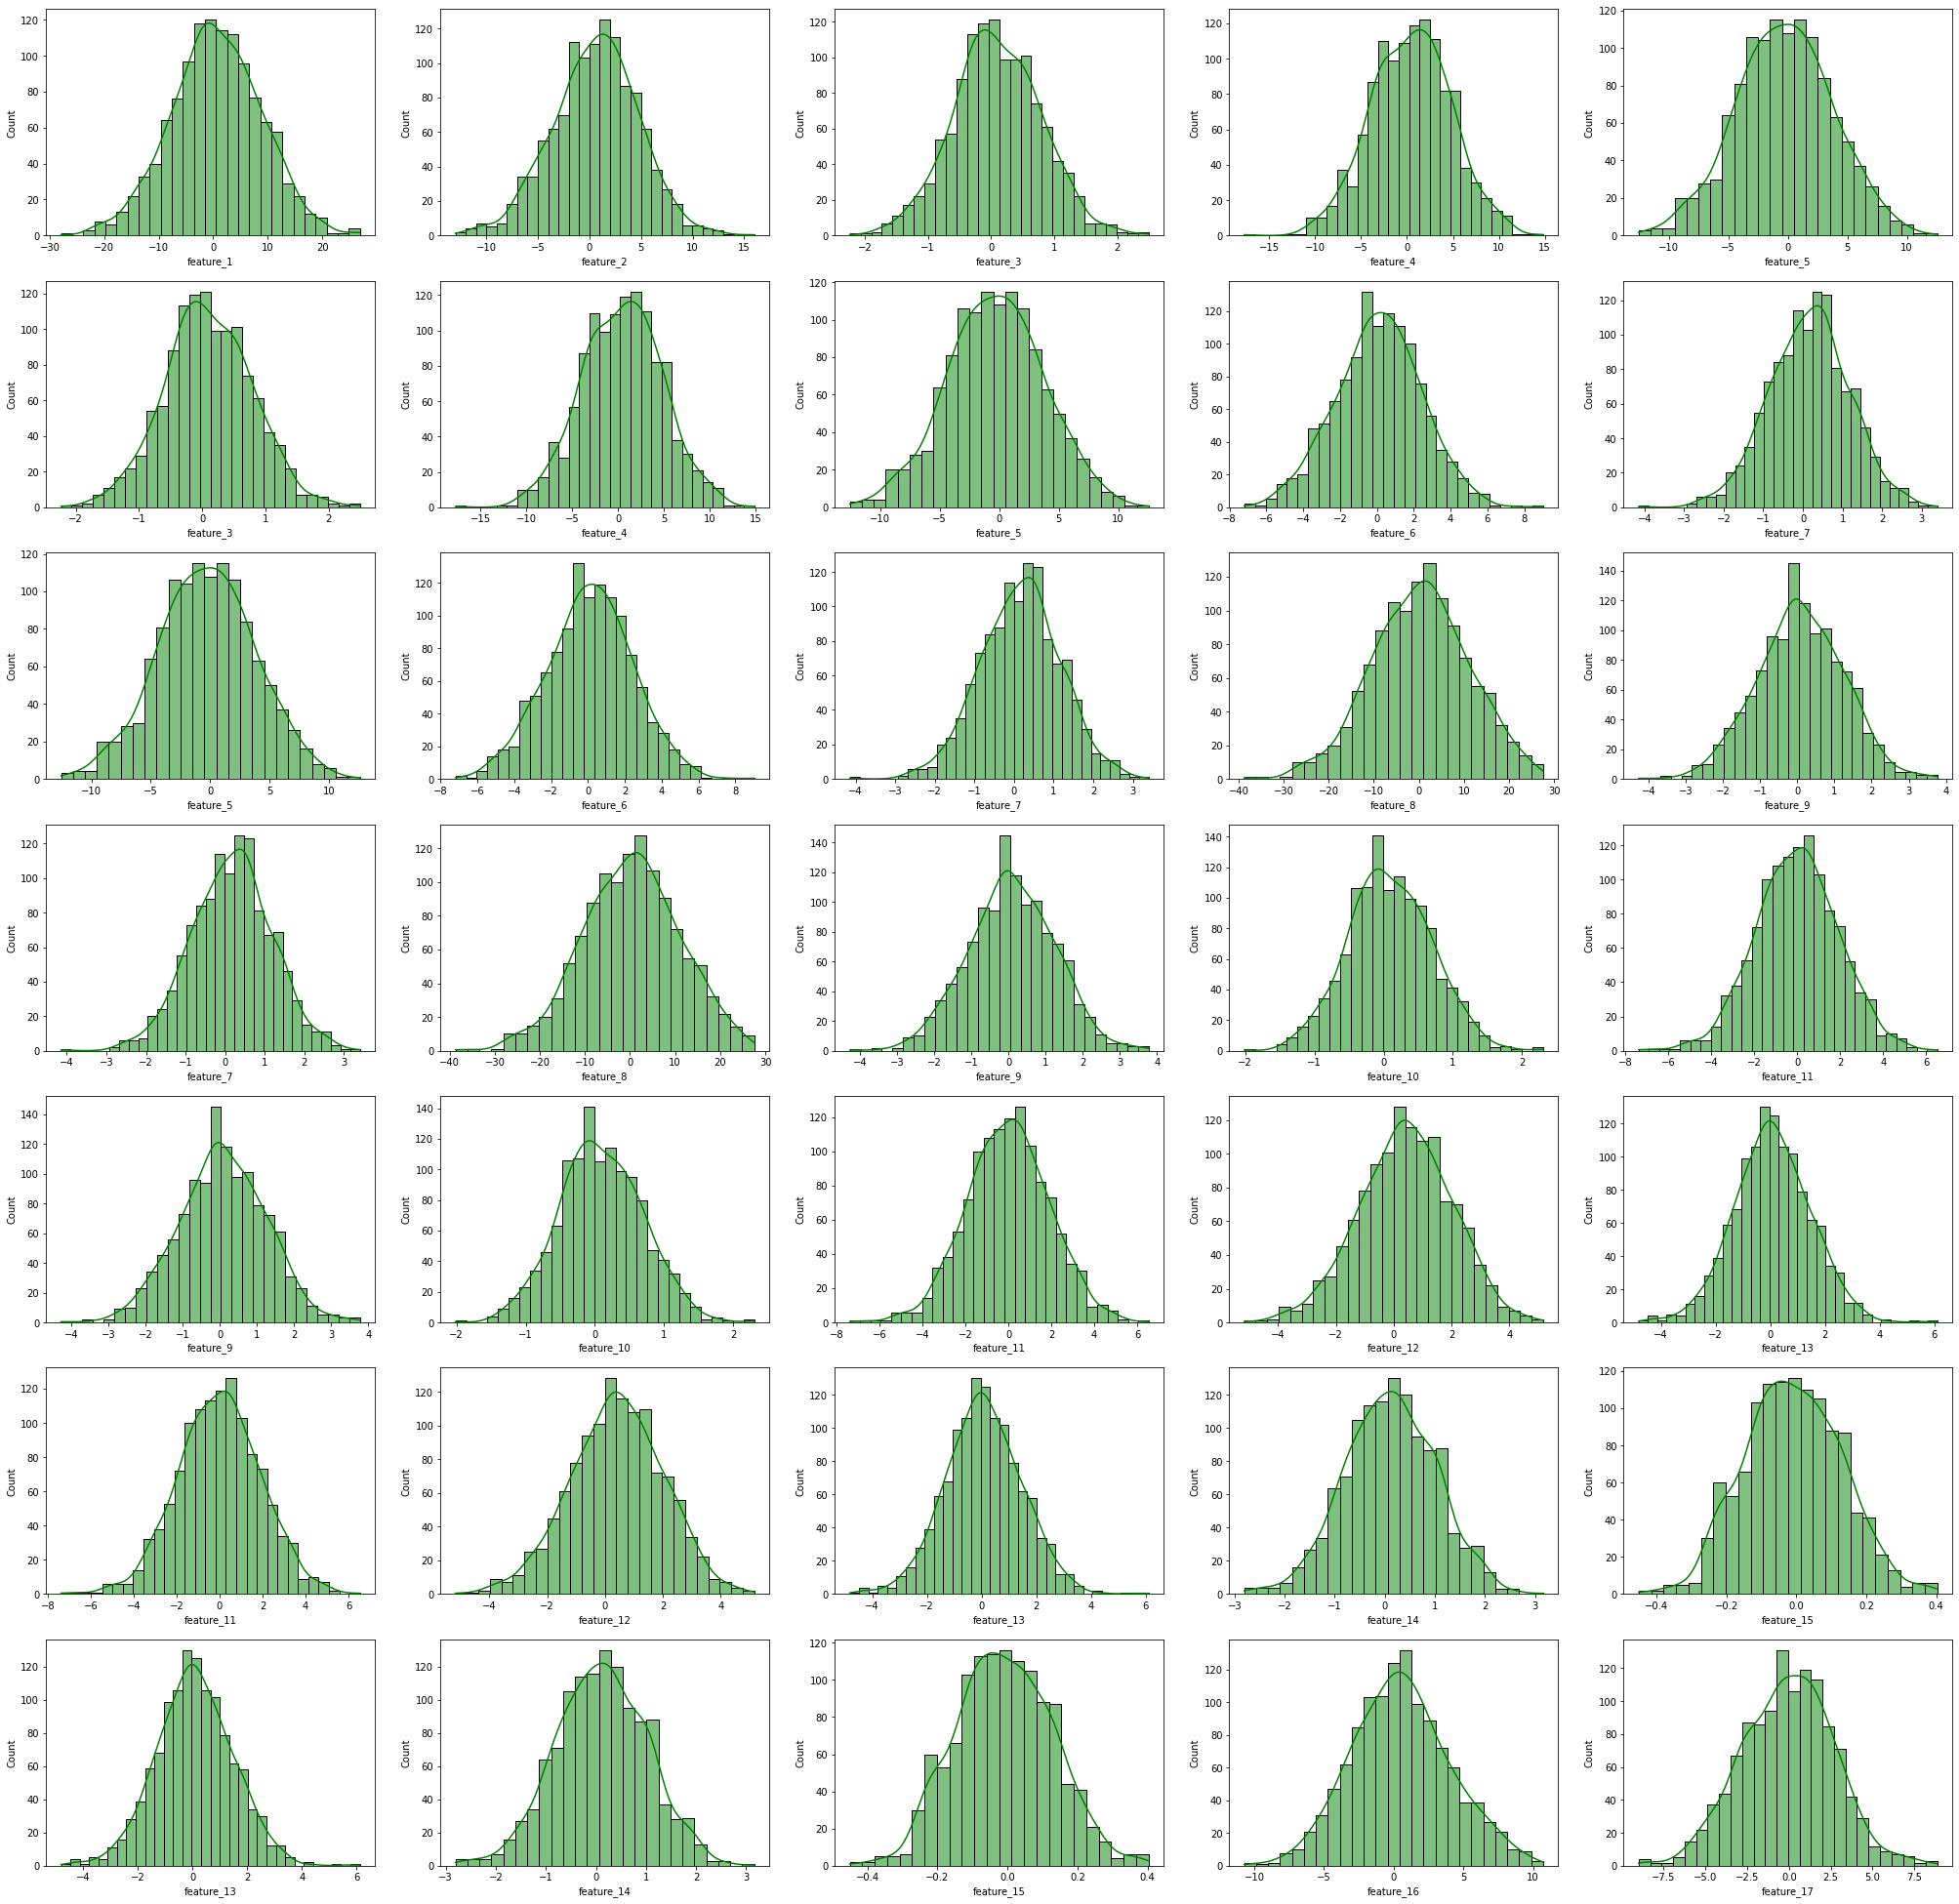

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(7, 5, figsize=(35, 35))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.histplot(features[features.columns[i*2+j]], ax=ax[i][j],kde=True,color='g')

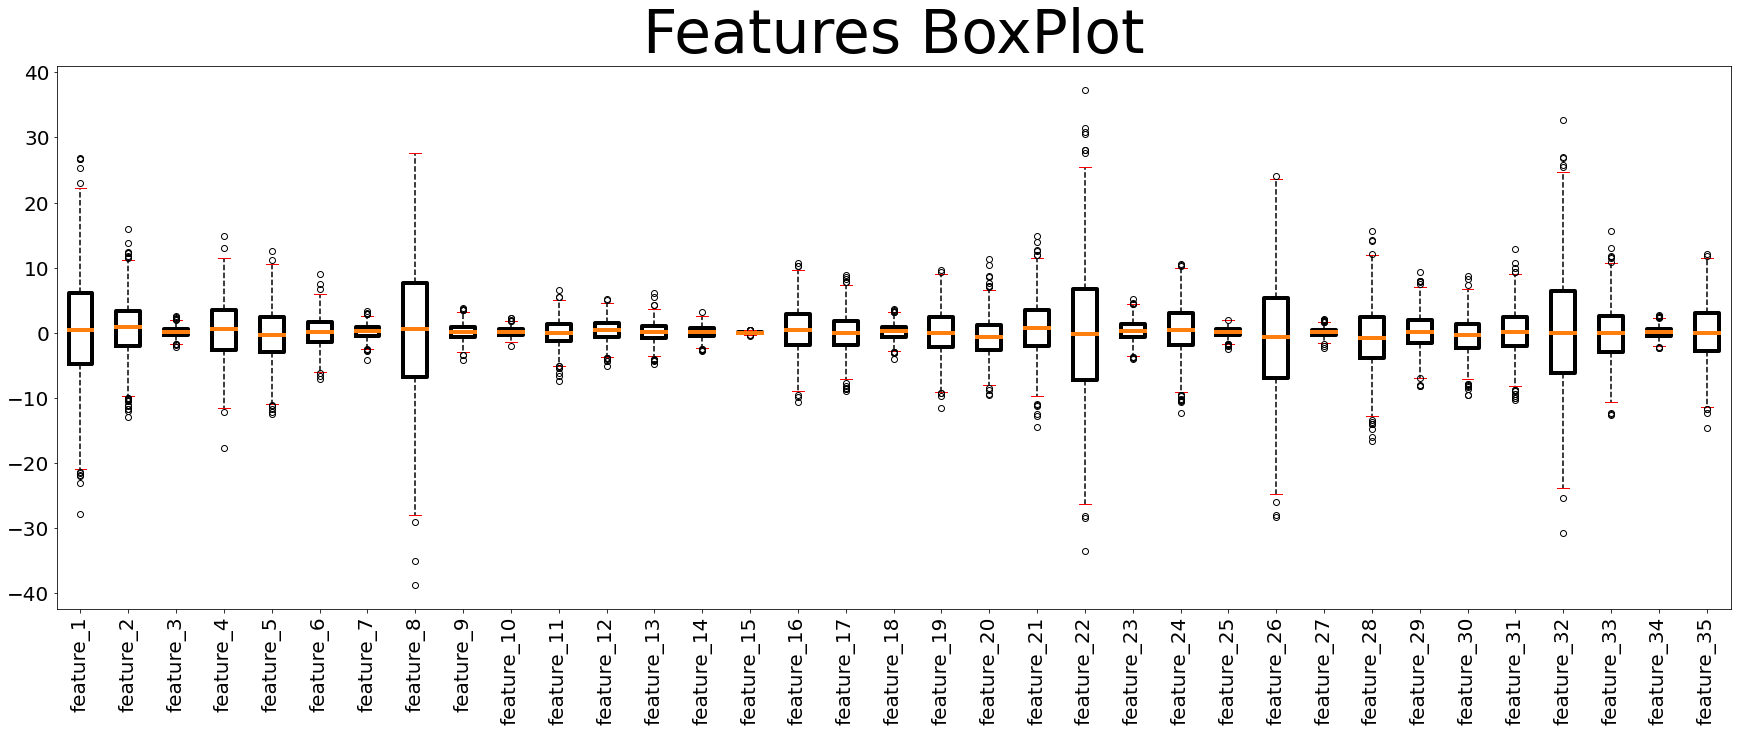

In [45]:
fig = features.boxplot(figsize=(30,10), grid=False, fontsize=20,rot=90, medianprops = dict(linewidth=4),
                        boxprops = dict(linewidth=4), whiskerprops = dict(linestyle='--',linewidth=1.5,
                        color='black'),capprops=dict(color='r'))
title = fig.set_title("Features BoxPlot", fontsize=60)

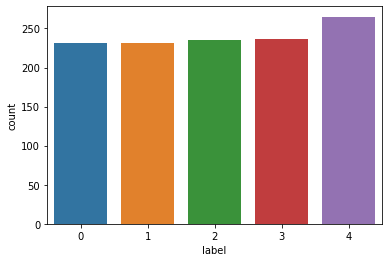

In [6]:
fig = sns.countplot(labels)

In Order to find correlation betweeen labels and classes, I have built a function to OneHot Encode the 5 labels, and calculated the correlation between the binary transformed label and the features.

Then I plotted Everything with another function  that calculates the correlation matrix and plots only the columns corresponding to the labels

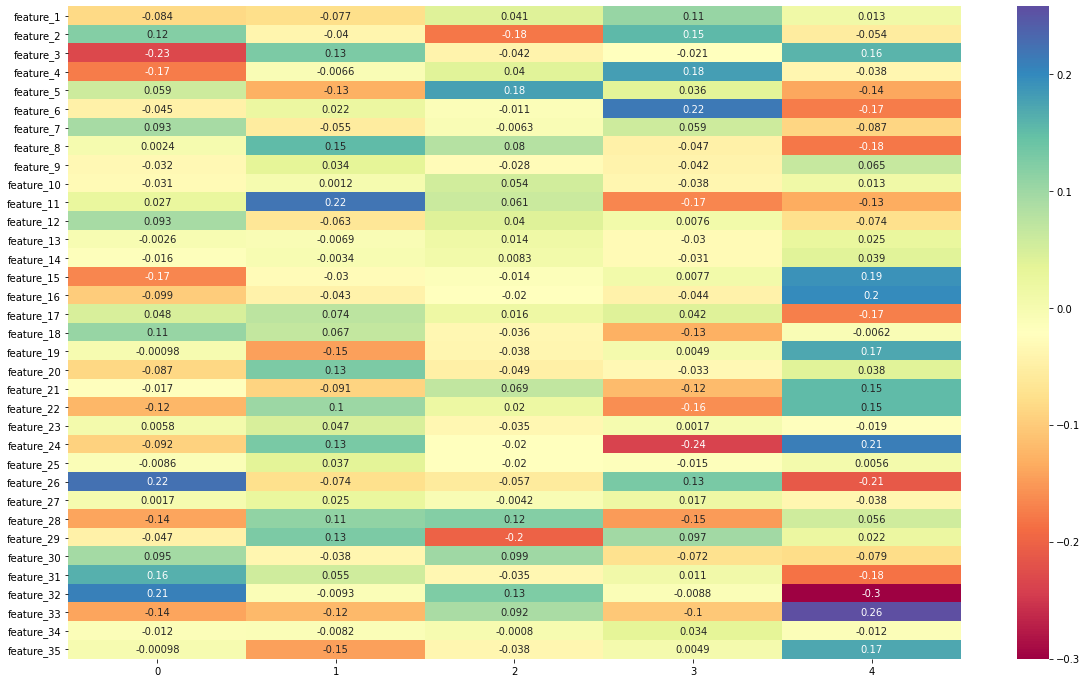

In [48]:
from sklearn.preprocessing import OneHotEncoder

def One_Hot_label_dataframe(features,df):
  enc = OneHotEncoder(handle_unknown='ignore')
  enc_df = pd.DataFrame(enc.fit_transform(df[['label']]).toarray())
  df = df.join(enc_df).drop(columns=['Unnamed: 0','label'])
  return df

def correlation(features,df):
  labels = sorted(df['label'].unique())
  df = One_Hot_label_dataframe(features,df)
  corr_matrix = df.corr()
  map = corr_matrix[labels][:'feature_35']
  fig, ax = plt.subplots(figsize=(20,12))
  sns.heatmap(map, annot=True,ax=ax,cmap='Spectral')
correlation(features,Data)

In order to apply Principal Component Analysis, the dataset should be centered at zero, which already is (more or less) as we have seen from the histograms and the boxplots, as a result scaling does not impact severly the precision of Logistic Regrssion

In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
model = LogisticRegression(max_iter=1000)

def scaling_effects(scalers,features,labels,model):  
  for scaler in scalers:
    pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
    scores = cross_val_score(pipeline, features, labels, cv = KFold(n_splits=10))
    print(f'Accuracy with {scaler}: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

scaling_effects(scalers,features,labels,model)

Accuracy with None: 0.527 (0.052)
Accuracy with StandardScaler(copy=True, with_mean=True, with_std=True): 0.527 (0.052)
Accuracy with MinMaxScaler(copy=True, feature_range=(0, 1)): 0.525 (0.048)
Accuracy with MaxAbsScaler(copy=True): 0.526 (0.058)


Principal Component Analysis

PCA may serve for the following purposes:
- Visualization (if we can get it down to 2 or 3 dimensions), e.g. for exploratory data analysis 
- Reduce computational load
- Reduce noise

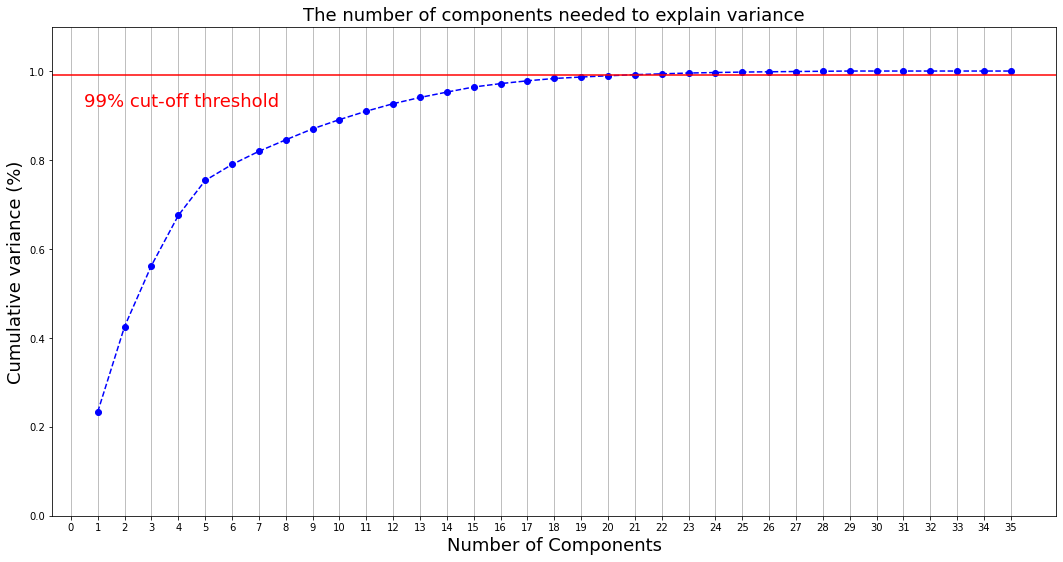

In [80]:
def evaluate_pca_explained_variance(X,scaler=None):
  if scaler is not None:
    X = scaler.fit_transform(X)
  pca = PCA().fit(X)

  fig, ax = plt.subplots()
  xi = np.arange(1, X.shape[1]+1, step=1)
  y = np.cumsum(pca.explained_variance_ratio_)

  plt.rcParams["figure.figsize"] = (18,9)
  plt.ylim(0.0,1.1)
  plt.xlabel('Number of Components', fontsize=18)
  plt.xticks(np.arange(0, 36, step=1)) #change from 0-based array index to 1-based human-readable label
  plt.ylabel('Cumulative variance (%)',fontsize=18)
  plt.title('The number of components needed to explain variance',fontsize=18)
  plt.plot(xi, y, marker='o', linestyle='--', color='b')
  plt.axhline(y=0.99, color='r', linestyle='-')
  plt.text(0.5, 0.92, '99% cut-off threshold', color = 'red', fontsize=18)

  ax.grid(axis='x')
  plt.show()

evaluate_pca_explained_variance(features)

In [90]:
svd = np.linalg.svd
def get_optimal_number_of_components(X,explainatory_power):
    cov = np.dot(X,X.transpose())/float(X.shape[0])
    U,s,v = svd(cov)
    S_nn = np.cumsum(s)/sum(s)
    return np.sum(S_nn <= explainatory_power)

n_comp = get_optimal_number_of_components(features,0.99)
n_comp

20

PCA does not have negative effect on predictions, the Accuracy is exactly the same, but since the size of the dataset is reduced, the training and the optimization time is cut by a significant amount, even though the reduction only compresses 35 dimensions into 20 not to lose classification signal.

In [91]:
X_new = PCA(n_components = n_comp).fit_transform(features)

Preprocessing is phase is concluded, so now we split the dataset

In [94]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.20,train_size=0.80)